In [1]:
.libPaths(R.home('/opt/homebrew/Caskroom/miniforge/base/lib/R/library'))
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1011. NC Well Metals/P1011.2. Analyses/P1011.2.3. ML Visualizations/P1011.2.3.1. Confusion Matrix Figure/Output')
cur_date = "052225"

library(readxl)
library(tidyverse)
library(ggrepel)
library(tidytext)
library(ggsci)

#reading in files
as_confusion_matrix_df = data.frame(read_excel("Input/As_Prediction_Confusion_Matrix_051624.xlsx"), Outcome = "Arsenic")
mn_confusion_matrix_df = data.frame(read_excel("Input/Mn_Prediction_Confusion_Matrix_051724.xlsx"), Outcome = "Manganese")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
# creating 1 df
confusion_matrix_df = rbind(as_confusion_matrix_df, mn_confusion_matrix_df) %>%
    # removing balanced accuracy since the values are the same as AUC
    select(-Balanced.Accuracy) %>%
    mutate(Outcome = ifelse(Outcome == "Arsenic", "(A) Arsenic", "(B) Manganese"))

head(confusion_matrix_df)

,Model,Use_Case,Kernel,Sensitivity,Specificity,PPV,NPV,AUC,Outcome
,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,RF Classification,1,NA,0.6225071,0.8862069,0.5560080,0.9114514,0.7543570,(A) Arsenic
2,RF Classification,2,NA,0.5621083,0.8913793,0.5438852,0.8993424,0.7267438,(A) Arsenic
3,RF Classification,3,NA,0.4384615,0.8709696,0.4534548,0.8721466,0.6547156,(A) Arsenic
4,RF Classification,4,NA,0.7116809,0.8384321,0.5022757,0.9279459,0.7750565,(A) Arsenic
5,SVM,1,svmLinear,0.7500000,0.8491379,0.5270270,0.9380952,0.7995690,(A) Arsenic
6,SVM,1,svmRadial,0.5769231,0.8922414,0.5454545,0.9039301,0.7345822,(A) Arsenic


In [3]:
# making the df longer based on the metrics
longer_confusion_matrix = confusion_matrix_df %>%
    pivot_longer(cols = 4:8, names_to = "Metric", values_to = "Value") %>%
    # cleaning up model names
    mutate(Model = ifelse(Model == "RF Classification", "Random Forest (RF)", "Support Vector Machine (SVM)")) %>%
    # only visualizing RF and linear SVM models
    filter(Kernel %in% c("svmLinear", NA)) 

# putting into a factor to reorder
#longer_confusion_matrix$Model = factor(longer_confusion_matrix$Model, levels = c("RF", "SVM"))
longer_confusion_matrix$Metric = factor(longer_confusion_matrix$Metric, levels = c("NPV", "PPV", "Specificity",
                                                                                    "Sensitivity", "AUC"))
    
head(longer_confusion_matrix)

Model,Use_Case,Kernel,Outcome,Metric,Value
<chr>,<dbl>,<chr>,<chr>,<fct>,<dbl>
Random Forest (RF),1,NA,(A) Arsenic,Sensitivity,0.6225071
Random Forest (RF),1,NA,(A) Arsenic,Specificity,0.8862069
Random Forest (RF),1,NA,(A) Arsenic,PPV,0.5560080
Random Forest (RF),1,NA,(A) Arsenic,NPV,0.9114514
Random Forest (RF),1,NA,(A) Arsenic,AUC,0.7543570
Random Forest (RF),2,NA,(A) Arsenic,Sensitivity,0.5621083


In [4]:
# making the df longer based on the metrics
longer_confusion_matrix = confusion_matrix_df %>%
    pivot_longer(cols = 4:8, names_to = "Metric", values_to = "Value") %>%
    # cleaning up model names
    mutate(Model = ifelse(Model == "RF Classification", "Random Forest (RF)", "Support Vector Machine (SVM)")) %>%
    # only visualizing RF, linear SVM models, and a radial SVM for use case 4
    filter(Kernel == "svmLinear"| Use_Case == 4 & Kernel == 'svmRadial' & Outcome == "Arsenic") 

# putting into a factor to reorder
longer_confusion_matrix$Metric = factor(longer_confusion_matrix$Metric, levels = c("NPV", "PPV", "Specificity",
                                                                                    "Sensitivity", "AUC"))
unwanted_data = longer_confusion_matrix %>%
    filter(Outcome == "Arsenic" & Kernel == 'svmLinear' & Use_Case == 4)

longer_confusion_matrix = anti_join(longer_confusion_matrix, unwanted_data)
    
head(longer_confusion_matrix)

Joining with `by = join_by(Model, Use_Case, Kernel, Outcome, Metric, Value)`


Model,Use_Case,Kernel,Outcome,Metric,Value
<chr>,<dbl>,<chr>,<chr>,<fct>,<dbl>
Support Vector Machine (SVM),1,svmLinear,(A) Arsenic,Sensitivity,0.7500000
Support Vector Machine (SVM),1,svmLinear,(A) Arsenic,Specificity,0.8491379
Support Vector Machine (SVM),1,svmLinear,(A) Arsenic,PPV,0.5270270
Support Vector Machine (SVM),1,svmLinear,(A) Arsenic,NPV,0.9380952
Support Vector Machine (SVM),1,svmLinear,(A) Arsenic,AUC,0.7995690
Support Vector Machine (SVM),2,svmLinear,(A) Arsenic,Sensitivity,0.7115385


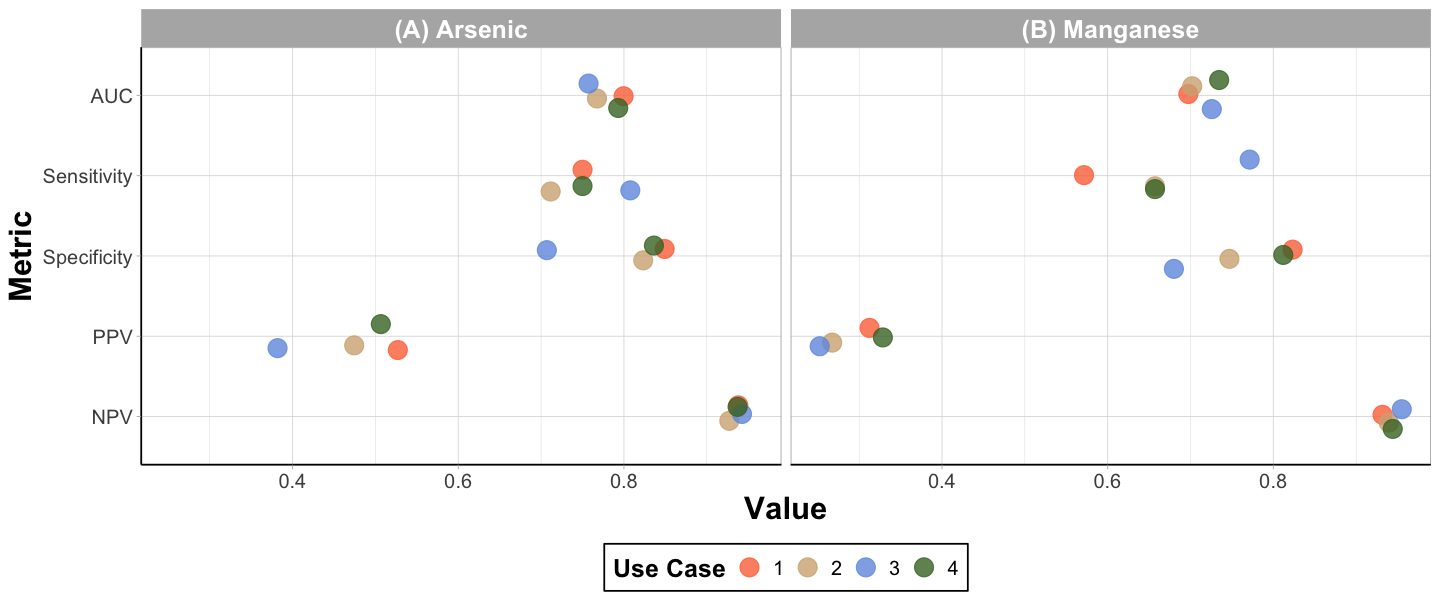

In [5]:
options(repr.plot.width=12, repr.plot.height=5) #changing size

# choosing palette from package
simpson_colors = pal_simpsons()(9)

Figure2 = ggplot() + 
  geom_point(data = longer_confusion_matrix, aes(x = Value, y = Metric, color = as.factor(Use_Case)), 
             position = position_jitter(h = 0.2), size = 5, alpha = 0.8) + 

  facet_wrap(~Outcome) +

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  xlab('Value') + ylab('Metric') + #changing axis labels 

  scale_color_manual(name = "Use Case", 
                     values = simpson_colors[c(5,4,2,9)]
                    ) 
 
Figure2

In [6]:
# exporting figure
ggsave(Figure2, 
       filename = 'Figure2.pdf',
       path = Output,
       width = 12, height = 5)